In [1]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import torch
import numpy as np
import jax.numpy as jnp

import matplotlib.pyplot as plt
from multiprocessing import Pool

from ml_collections import ConfigDict
from scipy.interpolate import griddata, interp2d
from matplotlib.animation import FuncAnimation, PillowWriter

from nv_files.train_nvs import initial_conditions_samples,ic_vort_samples,data_set_cat,sample_indices_ic
from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
from nv_files.data_generator import solve_poisson_fft,compute_velocity,UniformSampler
#from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D
from nv_files.NavierStokes import NavierStokes, Vorticity

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


# PINN

In [4]:
MDNN_model = torch.load(f"./models/MDNN_rnd.pth")
MDNN_model.eval()

mdnn_model = torch.load(f"./models/vorticity_MDNN.pth")
mdnn_model.eval()

Vorticity(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=256, out_features=256, bias=True)
    (v_layer): Linear(in_features=256, out_features=256, bias=True)
    (hidden_layers): ModuleList(
      (0-3): 4 x Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

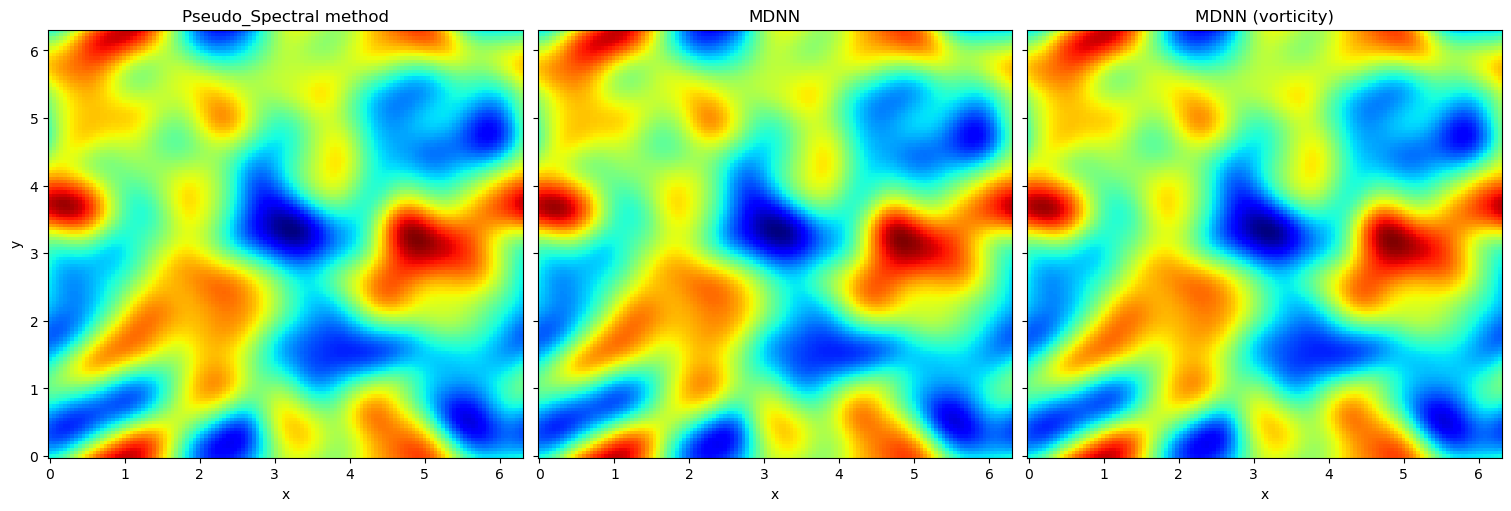

In [6]:
N = 128
seed = 108
N_KL = 50
xgrid = np.linspace(0,2*np.pi,N)
X, Y = np.meshgrid(xgrid, xgrid)
rng = np.random.default_rng(seed)
theta = rng.normal(0, 1, (N_KL, 2,1))

import jax.numpy as jnp

data = jnp.load("./data/ns_tori.npy", allow_pickle=True).item()
w_ref = data["w"]

#w0 = omega0_samples_torch(X, Y, theta, d = 5,tau=10)

solver = VorticitySolver2D(N=128, L=1, T=3, nu=1e-2, dt=5e-4,num_sol=200, method='CN', force=None)

w_list = solver.run_simulation( np.array(w_ref[0,:,:]))
time_array = np.linspace(5e-4, 3, int(1/ 5e-4))
points = np.linspace(0, len(time_array) - 1, 200, dtype=int)


time_steps = [0] + list(time_array[points])

batch_size_initial = 128

X = torch.linspace(0, 1, batch_size_initial)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, batch_size_initial)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

fig, axs = plt.subplots(1,3,figsize = (15,5), layout='constrained', sharey=True)

def animate(i):

    axs[0].clear()
    axs[1].clear()
    axs[2].clear()

    delta_t = time_steps[i]
    w0 = w_list[i]

    data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),delta_t*torch.ones_like(X.reshape(-1,1)))).float()

    wrf_pred = MDNN_model.w_net(data_test).detach().numpy()
    mdnn_pred = mdnn_model.w(data_test).detach().numpy()

    w_pred_mdnn = griddata((X.reshape(-1), Y.reshape(-1)), mdnn_pred.flatten(), (X, Y), method='cubic')
    w_pred_wrfdnn = griddata((X.reshape(-1), Y.reshape(-1)), wrf_pred.flatten(),(X, Y), method='cubic')

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0].pcolormesh(X, Y, w0, cmap='jet')
    #fig.colorbar(im1)
    axs[0].set_title("Pseudo_Spectral method")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("y")

    im2 = axs[1].pcolormesh(X, Y, w_pred_wrfdnn, cmap='jet')
    #fig.colorbar(im2)
    axs[1].set_title("MDNN")
    axs[1].set_xlabel("x")

    im3 = axs[2].pcolormesh(X, Y, w_pred_mdnn, cmap='jet')
    #fig.colorbar(im3)
    axs[2].set_title("MDNN (vorticity)")
    axs[2].set_xlabel("x")

    return im1, im2, im3

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
ani.save("./results/NV_NNs.gif", dpi=300, writer=PillowWriter(fps=25))

# Deep Galerkin

In [2]:
def get_deepgalerkin_config():
    config = ConfigDict()

    # Training settings
    config.seed = 0

    config.chunks = 16
    config.points_per_chunk = 180 

    # For deep Galerkin
    config.dim_initial_condition = 128
    config.tau = np.sqrt(2)
    config.d = 5

    config.time_domain = 2
    config.NKL =  1
    config.samples_size_initial = 100
    
    return config

In [21]:
config = get_deepgalerkin_config()

#initial_points,w0,u0,v0,theta = initial_conditions_samples(config)
initial_points,w0,theta = ic_vort_samples(config)

WRF_MDNN_dg = torch.load(f"./models/vorticity_hl1_n300_s10_kl1.pth")
WRF_MDNN_dg.eval()

Vorticity(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=202, out_features=302, bias=True)
    (v_layer): Linear(in_features=202, out_features=302, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=202, out_features=302, bias=True)
    )
    (output_layer): Linear(in_features=302, out_features=2, bias=True)
  )
)

Text(0.5, 1.0, 'NN prediction w0')

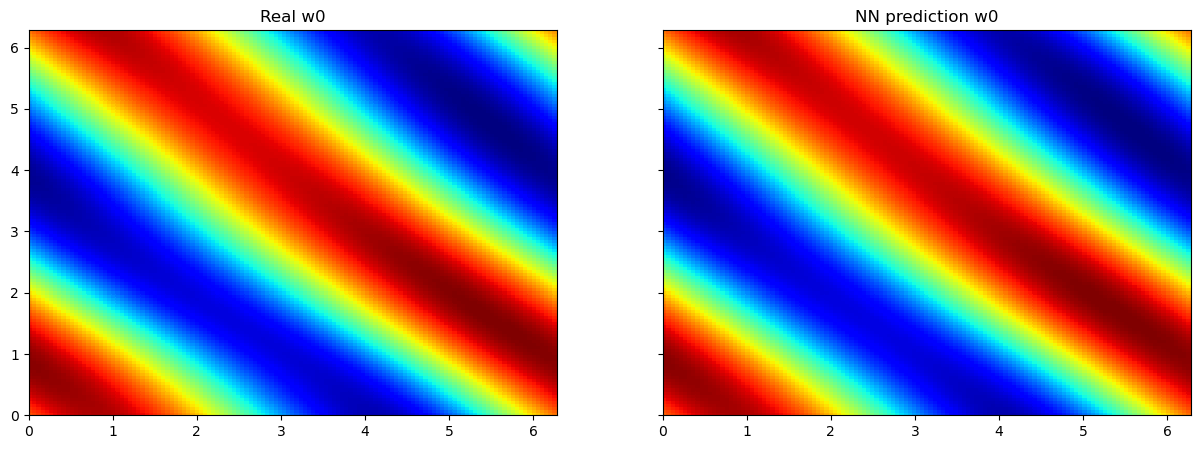

In [22]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

def force_function(X, Y):
    return  (np.sin(X + Y) + np.cos(X + Y))


i = 0

delta_t = 2

solver = VorticitySolver2D(N=128, L=2*np.pi, T=2, nu=1e-2, dt=5e-4,num_sol=100, method='CN', force=force_function)

w_ref1 = griddata((X.reshape(-1), Y.reshape(-1)), w0[:,i].flatten(),(X, Y), method='cubic')
#phi_ref1 = griddata((X.reshape(-1), Y.reshape(-1)), phi[:,i].flatten(),(X, Y), method='cubic')
w_list1 = solver.run_simulation( np.array(w_ref1))

data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),delta_t*torch.ones_like(X.reshape(-1,1)))).float()

th = theta[:,:,i].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)

dataset1 = torch.cat((data_test, th), dim=1)  # Shape (16000, 103)

w_pred1 = WRF_MDNN_dg.w(dataset1).detach().numpy()
phi_pred1 = WRF_MDNN_dg.phi(dataset1).detach().numpy()

pred1 = griddata((X.reshape(-1), Y.reshape(-1)), w_pred1.flatten(),(X, Y), method='cubic')
pred2 = griddata((X.reshape(-1), Y.reshape(-1)), phi_pred1.flatten(),(X, Y), method='cubic')

fig, axs = plt.subplots(1,2,figsize = (15,5),sharey=True)

axs[0].pcolormesh(X.numpy(),Y.numpy(),w_list1[-1], cmap='jet')
axs[0].set_title("Real w0")

axs[1].pcolormesh(X.numpy(),Y.numpy(), pred1, cmap='jet')
axs[1].set_title("NN prediction w0")

# axs[1,0].pcolormesh(X, Y, phi_ref1, cmap='jet')
# axs[1,0].set_title("Real phi0")

# axs[1,1].pcolormesh(X, Y, pred2, cmap='jet')
# axs[1,1].set_title("NN prediction phi0")

In [ ]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

error_list = []

def force_function(X, Y):
    return  (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=128, L=1, T=2, nu=1e-2, dt=5e-4,num_sol=100, method='CN', force=force_function)

for i in range(w0.shape[-1]):
    #phi_ref1 = griddata((X.reshape(-1), Y.reshape(-1)), phi[:,i].flatten(),(X, Y), method='cubic')

    data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

    th = theta[:,:,i].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)

    dataset1 = torch.cat((data_test, th), dim=1)  # Shape (16000, 103)

    w_pred1 = WRF_MDNN_dg.w(dataset1).detach().numpy()

    pred1 = griddata((X.reshape(-1), Y.reshape(-1)), w_pred1.flatten(),(X, Y), method='cubic')
    
    w_ref1 = griddata((X.reshape(-1), Y.reshape(-1)), w0[:,i].flatten(),(X, Y), method='cubic')

    w_list1 = solver.run_simulation(np.array(w_ref1))   

    aux = np.linalg.norm(w_list1[-1],ord=2)
    
    error_list.append((np.linalg.norm(pred1 - w_list1[-1],ord=2)) / aux)


In [ ]:

X = torch.linspace(0, 1, 512,device =)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 512)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y


def force_function(X, Y):
    return  (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=512, L=1, T=2, nu=1e-2, dt=5e-4,num_sol=100, method='CN', force=force_function)

# Define function for parallel execution
def process_iteration(i):
    w_ref1 = griddata((X.reshape(-1), Y.reshape(-1)), w0[:, i].flatten(), (X, Y), method='cubic')

    data_test = torch.hstack((X.reshape(-1,1), Y.reshape(-1,1), 2*torch.ones_like(X.reshape(-1,1)))).float()
    
    th = theta[:,:,i].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
    
    dataset1 = torch.cat((data_test, th), dim=1)  # Shape (16000, 103)
    
    w_pred1 = WRF_MDNN_dg.w(dataset1).detach().numpy()
    
    pred1 = griddata((X.reshape(-1), Y.reshape(-1)), w_pred1.flatten(), (X, Y), method='cubic')
    
    w_list1 = solver.run_simulation(np.array(w_ref1))
    
    aux = np.linalg.norm(w_list1[-1], ord=2)
    error = (np.linalg.norm(pred1 - w_list1[-1], ord=2)) / aux
    
    return error

with Pool() as pool:
    error_list = pool.map(process_iteration, range(w0.shape[-1]))

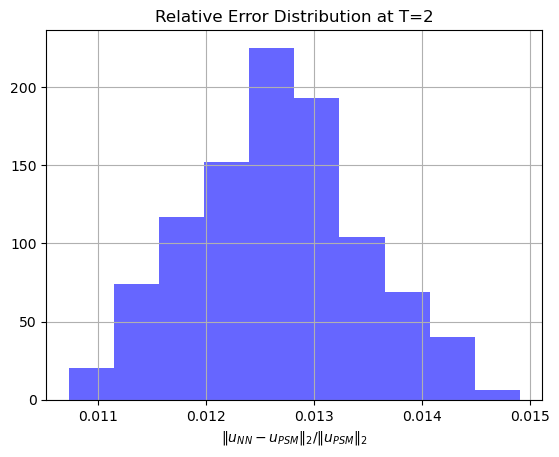

In [81]:
plt.title("Relative Error Distribution at T=2")
plt.hist(error_list, alpha=0.6, color="blue")
plt.xlabel(r"$\|u_{NN}-u_{PSM}\|_{2} /\|u_{PSM}\|_{2}$")
plt.grid(True)

In [27]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

def force_function(X, Y):
    return  (np.sin(X + Y) + np.cos(X + Y))

solver = VorticitySolver2D(N=128, L=1, T=2, nu=1e-2, dt=5e-4,num_sol=100, method='CN', force=force_function)

w_ref1 = griddata((X.reshape(-1), Y.reshape(-1)), w0[:,3].flatten(),(X, Y), method='cubic')
w_ref2 = griddata((X.reshape(-1), Y.reshape(-1)), w0[:,4].flatten(),(X, Y), method='cubic')


w_list1 = solver.run_simulation( np.array(w_ref1))
w_list2 = solver.run_simulation( np.array(w_ref2))

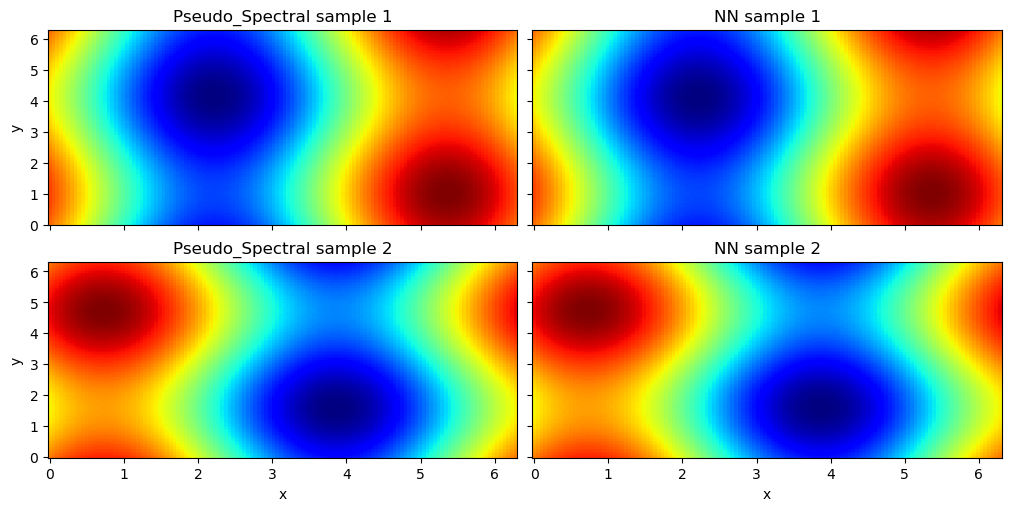

In [28]:
time_array = np.linspace(5e-4, 2, int(1/ 5e-4))
points = np.linspace(0, len(time_array) - 1, 100, dtype=int)

time_steps = [0] + list(time_array[points])

fig, axs = plt.subplots(2,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

def animate(i):
    axs[0,0].clear()
    axs[1,0].clear()
    axs[0,1].clear()
    axs[1,1].clear()

    delta_t = time_steps[i]
    w01 = w_list1[i]
    w02 = w_list2[i]

    data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),delta_t*torch.ones_like(X.reshape(-1,1)))).float()

    th1 = theta[:,:,3].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
    th2 = theta[:,:,4].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)

    dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)
    dataset2 = torch.cat((data_test, th2), dim=1)  # Shape (16000, 103)

    nn_pred1 = WRF_MDNN_dg.w(dataset1).detach().numpy()
    nn_pred2 = WRF_MDNN_dg.w(dataset2).detach().numpy()

    pred1 = griddata((X.reshape(-1), Y.reshape(-1)), nn_pred1.flatten(),(X, Y), method='cubic')
    pred2 = griddata((X.reshape(-1), Y.reshape(-1)), nn_pred2.flatten(),(X, Y), method='cubic')

    # Plot the first subplot (Solution Visualization for u_0)
    im1 = axs[0,0].pcolormesh(X, Y, w01, cmap='jet')
    axs[0,0].set_title("Pseudo_Spectral sample 1")
    axs[0,0].set_ylabel("y")

    im2 = axs[1,0].pcolormesh(X, Y, w02, cmap='jet')
    axs[1,0].set_title("Pseudo_Spectral sample 2")
    axs[1,0].set_xlabel("x")
    axs[1,0].set_ylabel("y")

    im3 = axs[0,1].pcolormesh(X, Y, pred1, cmap='jet')
    axs[0,1].set_title("NN sample 1")

    im4 = axs[1,1].pcolormesh(X, Y, pred2, cmap='jet')
    axs[1,1].set_title("NN sample 2")
    axs[1,1].set_xlabel("x")

    return im1,im2,im3,im4

ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
ani.save("./results/NV_NN_dg_2.gif", dpi=300, writer=PillowWriter(fps=25))